In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [33]:
from torchvision import datasets,models,transforms
from torch.utils.data import DataLoader, Dataset,ConcatDataset

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import os

import cv2
import torchvision
import copy
import tqdm
from PIL import Image
import zipfile




In [34]:
lr =0.001
batch_size=100
epochs = 10


In [35]:
device="cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(1234)
if device == 'cuda':
    torch.cuda.manual_seed_all(1234)

In [36]:
# Load train and test data
train_dir = '/home/zeus/Documents/Vashie/train'
test_dir = '/home/zeus/Documents/Vashie/test1'
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))







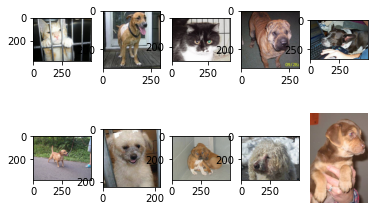

In [37]:
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [38]:
train_list[0].split('/')[-1].split('.')[0]

'dog'

In [39]:
train_transforms =transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    
    
])

val_transforms  =transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    
    
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    
    
])




In [40]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform = None):
        self.file_list=file_list
        self.transform=transform
    
    def __len__(self):
        self.filelength =len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path =self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
        
        return img_transformed,label
            
            
            
            
        
        
        
        
        
    

In [41]:
from sklearn.model_selection import train_test_split
train_list,val_list = train_test_split(train_list , test_size =0.2)

In [42]:
train_data = dataset(train_list,transform=train_transforms)
test_data = dataset(test_list,transform=test_transforms)
val_data = dataset(val_list,transform=test_transforms)



In [43]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size,shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size,shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size = batch_size,shuffle = True)

In [44]:
print(len(train_data),len(train_loader))
print(len(val_data), len(val_loader))


20000 200
5000 50


In [45]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [46]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        
        )
        
         
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,padding=0,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        
        )
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out =self.layer1(x)
        out =self.layer2(out)
        out =self.layer3(out)
        out =out.view(out.size(0),-1)
        out =self.relu(self.fc1(out))
        out =self.fc2(out)
        return out
    
        

In [47]:
model = Cnn().to(device)
model.train()
optimizer = optim.Adam(params = model.parameters(),lr =0.001)
criterion = nn.CrossEntropyLoss()

In [48]:
epochs = 10

for epoch in range(epochs):
    epoch_loss =0
    epoch_accuracy = 0
    
    for data,label in train_loader:
        data= data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1)==label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        
    with torch.no_grad():
        epoch_val_accuracy =0
        epoch_val_loss = 0
        for data,label in  val_loader:
            data= data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(output,label)


            acc = ((output.argmax(dim=1)==label).float().mean())
            epoch_val_accuracy += acc/len(val_loader)
            epoch_val_loss += val_loss/len(val_loader)
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            

Epoch : 1, train accuracy : 0.648600161075592, train loss : 0.6236559748649597
Epoch : 1, val_accuracy : 0.5094000101089478, val_loss : 0.845694363117218
Epoch : 2, train accuracy : 0.7031501531600952, train loss : 0.5685318112373352
Epoch : 2, val_accuracy : 0.49379992485046387, val_loss : 0.8801682591438293
Epoch : 3, train accuracy : 0.7297000288963318, train loss : 0.5339964628219604
Epoch : 3, val_accuracy : 0.5013999938964844, val_loss : 0.9176059365272522
Epoch : 4, train accuracy : 0.7439501285552979, train loss : 0.5097344517707825
Epoch : 4, val_accuracy : 0.5078000426292419, val_loss : 0.9246460199356079
Epoch : 5, train accuracy : 0.7570499181747437, train loss : 0.49333611130714417
Epoch : 5, val_accuracy : 0.5173999667167664, val_loss : 0.9968610405921936
Epoch : 6, train accuracy : 0.7650998830795288, train loss : 0.48204943537712097
Epoch : 6, val_accuracy : 0.5005999803543091, val_loss : 1.0027045011520386
Epoch : 7, train accuracy : 0.7671000361442566, train loss : 0.

In [49]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

In [51]:
dog_probs.sort(key = lambda x: int(x[0]))
dog_probs

[('1', 0.8525860905647278),
 ('2', 0.8736806511878967),
 ('3', 0.949889600276947),
 ('4', 0.6524897217750549),
 ('5', 0.3731979429721832),
 ('6', 0.24665112793445587),
 ('7', 0.051743362098932266),
 ('8', 0.36388978362083435),
 ('9', 0.09494753181934357),
 ('10', 0.14058123528957367),
 ('11', 0.01881486363708973),
 ('12', 0.9719961881637573),
 ('13', 0.41798242926597595),
 ('14', 0.7474466562271118),
 ('15', 0.34784021973609924),
 ('16', 0.10548217594623566),
 ('17', 0.9127755165100098),
 ('18', 0.9869138598442078),
 ('19', 0.058051325380802155),
 ('20', 0.5967487096786499),
 ('21', 0.2555253505706787),
 ('22', 0.12693992257118225),
 ('23', 0.7446064949035645),
 ('24', 0.8776025772094727),
 ('25', 0.2103373408317566),
 ('26', 0.9267343282699585),
 ('27', 0.9398953318595886),
 ('28', 0.03203215450048447),
 ('29', 0.578519344329834),
 ('30', 0.9373779892921448),
 ('31', 0.9186656475067139),
 ('32', 0.8029870390892029),
 ('33', 0.9845370054244995),
 ('34', 0.3926376402378082),
 ('35', 0.0

In [52]:
idx = list(map(lambda x :x[0],dog_probs))
prob = list(map(lambda x :x[1],dog_probs))

In [53]:
submission = pd.DataFrame({'id':idx, 'label':prob})


In [57]:
submission


,id,label
0,1,0.852586
1,2,0.873681
2,3,0.949890
3,4,0.652490
4,5,0.373198
...,...,...
12495,12496,0.014506
12496,12497,0.348456
12497,12498,0.272239
12498,12499,0.836060


In [56]:
submission.to_csv('result.csv',index=False)


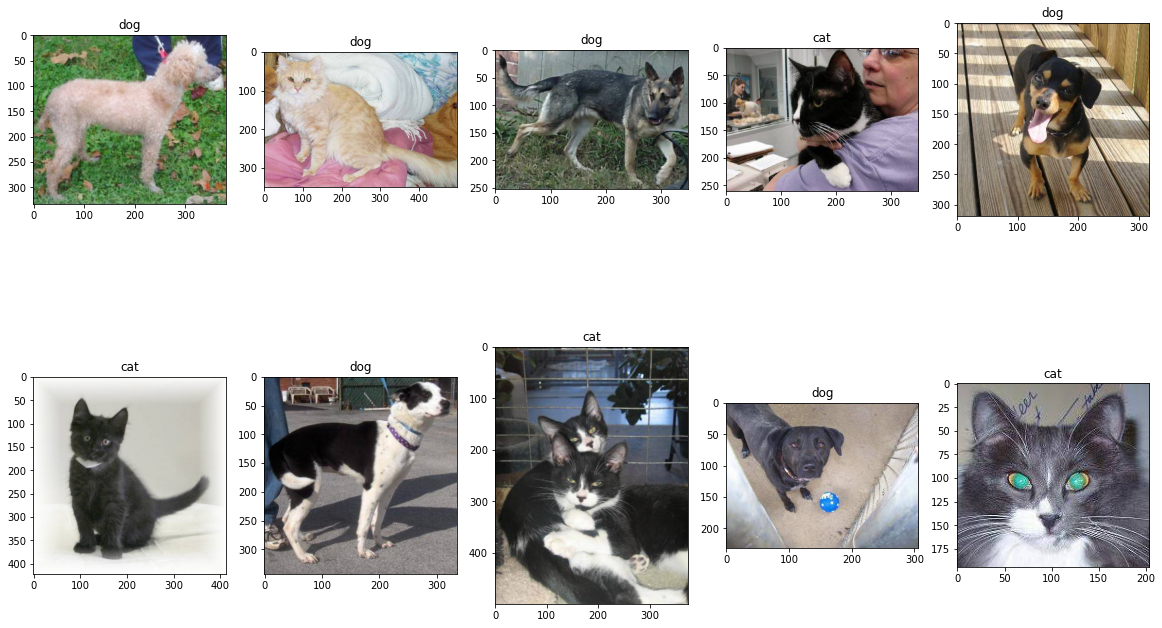

In [58]:
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)